In [47]:
import numpy as np
import pylab as plt
import torch
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import swyft
import random
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader



DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [48]:
# Define simulator parameters
f_low = 10
f_high = 1024
N_bins = 4076
freq = np.linspace(f_low, f_high, N_bins)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=len(freq), bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(f_low, f_high, N_bins)
        self.sample_z = swyft.RectBoundSampler([stats.uniform(-9,2), #omega
                                                stats.uniform(0,3)], #alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)
        #x = graph.node("x", lambda m: m + 0, m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

In [49]:
# Sample from Simulator

n_samples = 10000
fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
sims = sim.sample(N = n_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

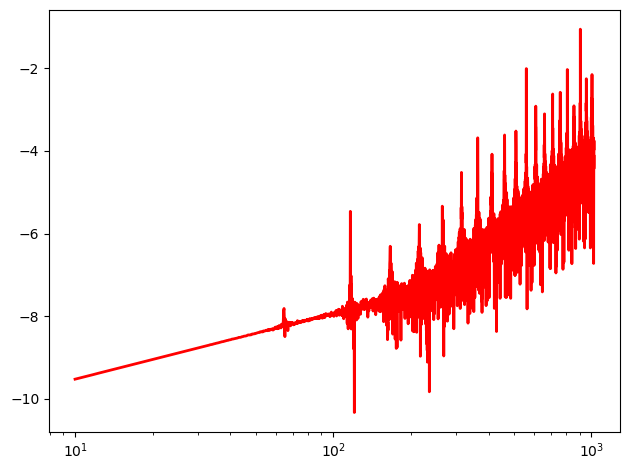

In [51]:
samples = swyft.Samples(x=np.log10(np.abs(sims['x'][1:])), z=sims['z'][1:]) # Samples for training network
obs = swyft.Sample(x=np.log10(np.abs(sims['x'][0])), z=sims['z'][0] ) # Example observation for inference

# Set aside observation parameters for later
obs_omega = sims['z'][0][0]
obs_alpha = sims['z'][0][1]

# Plot example observation
plt.semilogx(sim.freq, obs['x'], 'r', lw=2)
plt.tight_layout()
plt.show()

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Define VAE

class VAE(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = nn.Sequential(nn.Linear(4076, 1024),
                                        nn.Linear(1024, 256),
                                        nn.Linear(256, 64),
                                        nn.Linear(64, 16)

        )


        # Encoder layers (same as before, but with mu and logvar layers)
        #self.encoder_fc1 = nn.Linear(4076, 1024)
        #self.encoder_fc2 = nn.Linear(1024, 256)
        #self.encoder_fc3 = nn.Linear(256, 64)

        # Latent space mean and log variance
        #self.fc_mu = nn.Linear(64, 16)
       # self.fc_logvar = nn.Linear(64, 16)


        #self.dropout = nn.Dropout(0.2)

        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=16,  # Number of features in compressed x (simulated observation)
            num_params=2,    # Two parameters to infer: alpha and omega
            varnames='z',  # Names of the parameters
            num_blocks=4     # Number of neural network blocks
        )


    def forward(self, A, B): 
        s = self.summarizer(A['x'])
        return self.logratios(s, B['z'])


In [53]:
summarizer = nn.Sequential(nn.Linear(4076, 1024),
                                        nn.Linear(1024, 256),
                                        nn.Linear(256, 64),
                                        nn.Linear(64, 16)

        )
np.shape(summarizer(torch.tensor(samples['x'])))

torch.Size([9999, 16])

In [54]:
trainer = swyft.SwyftTrainer(accelerator=DEVICE, precision=64)

# Step 4: Prepare the data module for training
dm = swyft.SwyftDataModule(samples, batch_size=128)

# Step 5: Instantiate and train the network
network = VAE()
trainer.fit(network, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/lexington/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | summarizer | Sequential             | 4.5 M  | train
1 | logratios  | LogRatioEstimator_1dim | 71.0 K | train
--------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.103    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/lexington/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/lexington/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Reloading best model: /Users/lexington/Desktop/SBI_SGWB_DSMMA/Abby/lightning_logs/version_27/checkpoints/epoch=3-step=252.ckpt


In [57]:
# Define priors
omega_prior = stats.loguniform(1e-8, 1e-7)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0, 1)            # Uniform distribution for alpha

# Sample 1000 points from the priors
z_omega = omega_prior.rvs(1000)
z_alpha = alpha_prior.rvs(1000)

# Sample 1000 points from the priors
z_alpha = alpha_prior.rvs(20000).reshape([20000,1])

# Create prior samples
prior_samples = swyft.Samples(z = z_alpha)
predictions = trainer.infer(network, obs, prior_samples)


swyft.plot_posterior(predictions, 'z[0]', smooth=2)
plt.axvline(obs_omega, color='red', linestyle='--', label='Observation')
plt.xlabel("Omega")
plt.legend()

swyft.plot_posterior(predictions, 'z[1]', smooth=2)
plt.axvline(obs_alpha, color='red', linestyle='--', label='Observation')
plt.xlabel("Alpha")
plt.legend()

plt.tight_layout()  # Adjust layout so labels don't overlap
plt.show()

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


ValueError: `trainer.predict()` only supports the `CombinedLoader(mode="sequential")` mode.